# Purpose

In an earlier notebook, I attemped to make a stock prediction model. This failed to say the least. However, I think there is still much to be salvaged from the attempt. Python code written for a foolish task (predicting the stock market) is not written in vain, but an ideal opportunity to learn some new skills. I had a ton of fun making the stock model, and I wanted to still show the process which ultimately is more important than the end result. After writing a ton of separate functions to act on stock data, I realized a much better approach was to make a class that could hold data and also had different functions for prediction, plotting, analysis and anything else that might be needed. Having already developed all of these functions separately, I thought it made a lot of sense to combine them into a single class. This notebook will build up the class, covering many data manipulation, plotting, and even modeling concepts in a single example! 

In [5]:
# Quandl for financial analysis, pandas and numpy for data manipulation
# fbprophet for additive models, #pytrends for Google trend data
import quandl
import pandas as pd
import numpy as np
import fbprophet
import pytrends
from pytrends.request import TrendReq

# matplotlib pyplot for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

In [35]:
# Class for analyzing and (attempting) to predict future prices
# Contains a number of visualizations and analysis methods
class Stocker():
    
    # Initialization requires a ticker symbol
    def __init__(self, ticker):
        
        # Enforce capitalization
        ticker = ticker.upper()
        
        # Symbol is used for labeling plots
        self.symbol = ticker
        
        # api personal key
        quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'

        # Retrieval the financial data
        try:
            stock = quandl.get('WIKI/%s' % ticker)
        
        except Exception as e:
            print('Error Retrieving Data.')
            print(e)
            return
        
        # Set the index to a column called Date
        stock = stock.reset_index(level=0)
        
        # Columns required for prophet
        stock['ds'] = stock['Date']
        stock['y'] = stock['Adj. Close']
        
        # Data assigned as class attribute
        self.stock = stock.copy()
        
        # Minimum and maximum date in range
        self.min_date = min(stock['Date'])
        self.max_date = max(stock['Date'])
        
        # Find max and min prices and dates on which they occurred
        self.max_price = np.max(self.stock['y'])
        self.min_price = np.min(self.stock['y'])
        
        self.min_price_date = self.stock[self.stock['y'] == self.min_price]['Date']
        self.min_price_date = self.min_price_date[self.min_price_date.index[0]]
        self.max_price_date = self.stock[self.stock['y'] == self.max_price]['Date']
        self.max_price_date = self.max_price_date[self.max_price_date.index[0]]
        
        # The starting price (starting with the opening price)
        self.starting_price = float(self.stock.ix[0, 'Adj. Open'])
        
        # The most recent price
        self.most_recent_price = float(self.stock.ix[len(self.stock) - 1, 'y'])
        
        # Prophet parameters
        self.changepoint_prior_scale = 0.2
        self.weekly_seasonality = False
        self.daily_seasonality = False
        self.monthly_seasonality = True
        self.yearly_seasonality = True
        self.changepoints = None
        
        print('{} Stocker Initialized. Data covers {} to {}.'.format(self.symbol,
                                                                     self.min_date.date(),
                                                                     self.max_date.date()))
        
    # Basic Historical Plot and Basic Statistics
    def plot_stock(self, start_date=None, end_date=None):
        
        self.reset_plot()
        
        # Default start and end date are the beginning and end of data
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
            
        # Convert to pandas date time
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        if end_date.date() < start_date.date():
            print('End Date must be later than start date.')
            return
        
        # Check to make sure dates are in the data
        if (start_date not in list(self.stock['Date'])):
            print('Start Date not in data (either out of range or not a trading day.)')
            return
        elif (end_date not in list(self.stock['Date'])):
            print('End Date not in data (either out of range or not a trading day.)')
            return 
            
        # Useful statistics
        print('Maximum price = ${:.2f} on {}.'.format(self.max_price, self.max_price_date.date()))
        print('Minimum price = ${:.2f} on {}.'.format(self.min_price, self.min_price_date.date()))
        print('Current price = ${:.2f}.'.format(self.most_recent_price))
        
        stock_plot = self.stock[(self.stock['Date'] >= start_date.date()) & (self.stock['Date'] <= end_date.date())]
        
        # Simple Plot 
        plt.style.use('fivethirtyeight');
        plt.plot(stock_plot['Date'], stock_plot['Adj. Close'], 'r-', linewidth = 3)
        plt.xlabel('Date'); plt.ylabel('Closing Price ($)'); plt.title('%s Stock Price History' % self.symbol); 
        plt.grid(color = 'k', alpha = 0.4); plt.show()
      
    # Reset the plotting parameters to clear style formatting
    # Not sure if this should be a static method
    @staticmethod
    def reset_plot():
        
        # Restore default parameters
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (8, 5)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'
    
    # Method to linearly interpolate prices on the weekends
    def resample(self, dataframe):
        # Change the index and resample at daily level
        dataframe = dataframe.set_index('ds')
        dataframe = dataframe.resample('D')
        
        # Reset the index and interpolate nan values
        dataframe = dataframe.reset_index(level=0)
        dataframe = dataframe.interpolate()
        return dataframe
    
    # Remove weekends from a dataframe
    def remove_weekends(self, dataframe):
        
        # Reset index to use ix
        dataframe = dataframe.reset_index(drop=True)
        
        weekends = []
        
        # Find all of the weekends
        for i, date in enumerate(dataframe['ds']):
            if (date.weekday()) == 5 | (date.weekday() == 6):
                weekends.append(i)
            
        # Drop the weekends
        dataframe = dataframe.drop(weekends, axis=0)
        
        return dataframe
    
    
    # Calculate and plot profit from buying and holding shares for specified date range
    def buy_and_hold(self, start_date=None, end_date=None, nshares=1):
        self.reset_plot()
        
        # Default start and end date are the beginning and end of data
        if start_date is None:
            start_date = self.min_date
        if end_date is None:
            end_date = self.max_date
            
        # Convert to pandas datetime for indexing dataframe
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        if end_date.date() < start_date.date():
            print('End Date must be later than start date.')
            return
        
        # Check to make sure dates are in the data
        if (start_date not in list(self.stock['Date'])):
            print('Start Date not in data (either out of range or not a trading day.)')
            return
        elif (end_date not in list(self.stock['Date'])):
            print('End Date not in data (either out of range or not a trading day.)')
            return 
        
        # Find starting and ending price of stock
        start_price = float(self.stock[self.stock['Date'] == start_date]['Adj. Open'])
        end_price = float(self.stock[self.stock['Date'] == end_date]['Adj. Close'])
        
        # Make a profit dataframe and calculate profit column
        profits = self.stock[(self.stock['Date'] >= start_date) & (self.stock['Date'] <= end_date)]
        profits['hold_profit'] = nshares * (profits['Adj. Close'] - start_price)
        
        # Total profit
        total_hold_profit = nshares * (end_price - start_price)
        
        print('{} Total buy and hold profit from {} to {} for {} shares = ${:.2f}'.format
              (self.symbol, start_date.date(), end_date.date(), nshares, total_hold_profit))
        
        # Plot the total profits 
        plt.style.use('dark_background')
        
        # Location for number of profit
        text_location = (end_date - pd.DateOffset(months = 1)).date()
        
        # Plot the profits over time
        plt.plot(profits['Date'], profits['hold_profit'], 'b', linewidth = 3)
        plt.ylabel('Profit ($)'); plt.xlabel('Date'); plt.title('Buy and Hold Profits for {} {} to {}'.format(
                                                                self.symbol, start_date.date(), end_date.date()))
        
        # Display final value on graph
        plt.text(x = text_location, 
             y =  total_hold_profit + (total_hold_profit / 40),
             s = '$%d' % total_hold_profit,
            color = 'g' if total_hold_profit > 0 else 'r',
            size = 14)
        
        plt.grid(alpha=0.2)
        plt.show();
        
    # Create a prophet model without training
    def create_model(self):

        # Make the model
        model = fbprophet.Prophet(daily_seasonality=self.daily_seasonality,  
                                  weekly_seasonality=self.weekly_seasonality, 
                                  yearly_seasonality=self.yearly_seasonality,
                                  changepoint_prior_scale=self.changepoint_prior_scale,
                                  changepoints=self.changepoints)
        
        if self.monthly_seasonality:
            # Add monthly seasonality
            model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
        
        return model
    
    # Graph the effects of altering the changepoint prior scale (cps)
    def changepoint_prior_analysis(self, changepoint_priors=[0.001, 0.05, 0.1, 0.2], colors=['b', 'r', 'grey', 'gold']):
    
        # Training and plotting with 4 years of data
        train = self.stock[(self.stock['Date'] > (max(self.stock['Date']) - pd.DateOffset(years=3)).date())]
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=180, freq='D')
            
            # Make a dataframe to hold predictions
            if i == 0:
                predictions = future.copy()
                
            future = model.predict(future)
            
            # Fill in prediction dataframe
            predictions['%.3f_yhat_upper' % prior] = future['yhat_upper']
            predictions['%.3f_yhat_lower' % prior] = future['yhat_lower']
            predictions['%.3f_yhat' % prior] = future['yhat']
         
        # Remove the weekends
        predictions = self.remove_weekends(predictions)
        
        # Plot set-up
        self.reset_plot()
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(1, 1)
        
        # Actual observations
        ax.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'Observations')
        color_dict = {prior: color for prior, color in zip(changepoint_priors, colors)}

        # Plot each of the changepoint predictions
        for prior in changepoint_priors:
            # Plot the predictions themselves
            ax.plot(predictions['ds'], predictions['%.3f_yhat' % prior], linewidth = 1.2,
                     color = color_dict[prior], label = '%.3f prior scale' % prior)
            
            # Plot the uncertainty interval
            ax.fill_between(predictions['ds'].dt.to_pydatetime(), predictions['%.3f_yhat_upper' % prior],
                            predictions['%.3f_yhat_lower' % prior], facecolor = color_dict[prior],
                            alpha = 0.3, edgecolor = 'k', linewidth = 0.6)
                            
        # Plot labels
        plt.legend(prop={'size': 10})
        plt.xlabel('Date'); plt.ylabel('Stock Price ($)'); plt.title('Effect of Changepoint Prior Scale');
        plt.show()
            
    # Basic prophet model for the next 365 days   
    def create_prophet_model(self, resample=False):
        
        self.reset_plot()
        
        model = self.create_model()
        
        # Fit on the stock history for past 3 years
        stock_history = self.stock[self.stock['Date'] > (self.max_date - pd.DateOffset(years = 3)).date()]
        
        if resample:
            stock_history = self.resample(stock_history)
        
        model.fit(stock_history)
        
        # Make and predict for next year with future dataframe
        future = model.make_future_dataframe(periods = 365, freq='D')
        future = model.predict(future)
        
        # Print the predicted price
        print('Predicted Price on {} = ${:.2f}'.format(
            future.ix[len(future) - 1, 'ds'].date(), future.ix[len(future) - 1, 'yhat']))
        
        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(stock_history['ds'], stock_history['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Predicted');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                       facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Uncertainty')

        # Put a vertical line at the start of predictions
        plt.vlines(x=max(self.stock['Date']).date(), ymin=min(future['yhat_lower']), 
                   ymax=max(future['yhat_upper']), colors = 'r',
                   linestyles='dashed')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Price $');
        plt.grid(linewidth=0.6, alpha = 0.6)
        plt.title('%s Historical and Predicted Stock Price'  % self.symbol);
        plt.show()
        
        return model, future
      
    # Evaluate prediction model for one year
    def evaluate_prediction(self, start_date=None, end_date=None, nshares = 1000):
        
        # Default start date is one year before end of data
        # Default end date is end date of data
        if start_date is None:
            start_date = self.max_date - pd.DateOffset(years=1)
        if end_date is None:
            end_date = self.max_date
            
        # Convert to pandas datetime for indexing dataframe
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        if end_date.date() < start_date.date():
            print('End Date must be later than start date.')
            return
        
        # Check to make sure dates are in the data
        if (start_date not in list(self.stock['Date'])):
            print('Start Date not in data (either out of range or not a trading day.)')
            return
        elif (end_date not in list(self.stock['Date'])):
            print('End Date not in data (either out of range or not a trading day.)')
            return 
        
        # Training data starts 3 years before start date and goes up to start date
        train = self.stock[(self.stock['Date'] < start_date.date()) & 
                           (self.stock['Date'] > (start_date - pd.DateOffset(years=3)).date())]
        
        # Testing data is specified in the range
        test = self.stock[(self.stock['Date'] >= start_date.date()) & (self.stock['Date'] <= end_date.date())]
        
        # Create and train the model
        model = self.create_model()
        model.fit(train)
        
        # Make a future dataframe and predictions
        future = model.make_future_dataframe(periods = 365, freq='D')
        future = model.predict(future)
        
        # Merge predictions with the known values
        test = pd.merge(test, future, on = 'ds', how = 'inner')
        
        # Calculate the differences between consecutive measurements
        test['pred_diff'] = test['yhat'].diff()
        test['real_diff'] = test['y'].diff()
        
        # Correct is when we predicted the correct direction
        test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
        
        # Accuracy when we predict increase and decrease
        increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
        decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])
        
        # Only playing the stocks when we predict the stock will increase
        test_pred_increase = test[test['pred_diff'] > 0]
        
        test_pred_increase.reset_index(inplace=True)
        prediction_profit = []
        
        # Iterate through all the predictions and calculate profit from playing
        for i, correct in enumerate(test_pred_increase['correct']):
            
            # If we predicted up and the price goes up, we gain the difference
            if correct == 1:
                prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
            # If we predicted up and the price goes down, we lose the difference
            else:
                prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
        
        test_pred_increase['pred_profit'] = prediction_profit
        
        # Put the profit into the test dataframe
        test = pd.merge(test, test_pred_increase[['ds', 'pred_profit']], on = 'ds', how = 'left')
        test.ix[0, 'pred_profit'] = 0
    
        # Profit for either method at all dates
        test['pred_profit'] = test['pred_profit'].cumsum().ffill()
        test['hold_profit'] = nshares * (test['y'] - float(test.ix[0, 'y']))
        
        # Display information
        print('You played the stock market in {} from {} to {} with {} shares.\n'.format(
            self.symbol, start_date.date(), end_date.date(), nshares))
        
        print('Predicted price on {} = ${:.2f}.'.format(max(future['ds']).date(), future.ix[len(future) - 1, 'yhat']))
        print('Actual price on    {} = ${:.2f}.\n'.format(max(test['ds']).date(), test.ix[len(test) - 1, 'y']))
        
        # Display some friendly information about the perils of playing the stock market
        print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
        print('When the model predicted a decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))
        print('The total profit using the Prophet model = ${:.2f}.'.format(np.sum(prediction_profit)))
        print('The Buy and Hold strategy profit =         ${:.2f}.'.format(float(test.ix[len(test) - 1, 'hold_profit'])))
        print('\nThanks for playing the stock market!\n')
        
        # Reset the plot
        self.reset_plot()
        
        # Set up the plot
        fig, ax = plt.subplots(1, 1)

        # Plot the actual values
        ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

        # Plot the uncertainty interval as ribbon
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                       facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Uncertainty')

        # Put a vertical line at the start of predictions
        plt.vlines(x=min(test['ds']).date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                   linestyles='dashed', label = 'Prediction Start')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price $');
        plt.grid(linewidth=0.6, alpha = 0.6)
                   
        plt.title('%s Prophet Evaluation for Past Year' % self.symbol);
        plt.show();
        
        # Plot the predicted and actual profits over time
        self.reset_plot()
        
        # Final profit and final smart used for locating text
        final_profit = test.ix[len(test) - 1, 'pred_profit']
        final_smart = test.ix[len(test) - 1, 'hold_profit']

        # text location
        last_date = test.ix[len(test) - 1, 'ds']
        text_location = (last_date - pd.DateOffset(months = 1)).date()

        plt.style.use('dark_background')

        # Plot smart profits
        plt.plot(test['ds'], test['hold_profit'], 'b',
                 linewidth = 1.8, label = 'Buy and Hold') 

        # Plot prediction profits
        plt.plot(test['ds'], test['pred_profit'], 
                 color = 'g' if final_profit > 0 else 'r',
                 linewidth = 1.8, label = 'Prediction')

        # Display final values on graph
        plt.text(x = text_location, 
                 y =  final_profit + (final_profit / 40),
                 s = '$%d' % final_profit,
                color = 'g' if final_profit > 0 else 'r',
                size = 18)
        
        plt.text(x = text_location, 
                 y =  final_smart + (final_smart / 40),
                 s = '$%d' % final_smart,
                color = 'g' if final_smart > 0 else 'r',
                size = 18);

        # Plot formatting
        plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
        plt.title('Predicted versus Buy and Hold Profits');
        plt.legend(loc = 2, prop={'size': 10});
        plt.grid(alpha=0.2); 
        plt.show()
        
    def retrieve_google_trends(self, term, date_range):
        
        # Set up the trend fetching object
        pytrends = TrendReq(hl='en-US', tz=360)
        kw_list = [term]

        try:
        
            # Create the search object
            pytrends.build_payload(kw_list, cat=0, timeframe=date_range[0], geo='', gprop='')
            
            # Retrieve the interest over time
            trends = pytrends.interest_over_time()

        except Exception as e:
            print('\nGoogle Search Trend retrieval failed.')
            print(e)
            return
        
        return trends
        
    def changepoint_date_analysis(self, term=None):
        self.reset_plot()
        
        if term is None:
            term = '%s stock' % self.symbol

        model = self.create_model()
        
        # Use past three years of data
        train = self.stock[self.stock['Date'] > (self.max_date - pd.DateOffset(years = 3)).date()]
        model.fit(train)
        
        # Predictions of the training data (no future periods)
        future = model.make_future_dataframe(periods=0, freq='D')
        future = model.predict(future)
    
        train = pd.merge(train, future[['ds', 'yhat']], on = 'ds', how = 'inner')
        
        changepoints = model.changepoints
        train = train.reset_index(drop=True)
        
        # Create dataframe of only changepoints
        change_indices = []
        for changepoint in (changepoints):
            change_indices.append(train[train['ds'] == changepoint.date()].index[0])
        
        c_data = train.ix[change_indices, :]
        deltas = model.params['delta'][0]
        
        c_data['delta'] = deltas
        c_data['abs_delta'] = abs(c_data['delta'])
        
        # Sort the values by maximum change
        c_data = c_data.sort_values(by='abs_delta', ascending=False)
        
        print('\nChangepoints sorted by slope rate of change (2nd derivative):\n')
        print(c_data.ix[:, ['Date', 'Adj. Close', 'delta']][:5])
    
    
        # Limit to 10 largest changepoints
        c_data = c_data[:10]
        
        # Line plot showing actual values, estimated values, and changepoints
        self.reset_plot()
        
        # Set up line plot 
        plt.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'Stock Price')
        plt.plot(future['ds'], future['yhat'], color = 'navy', linewidth = 2.0, label = 'Estimated')
        
        # Changepoints as vertical lines
        plt.vlines(c_data['ds'].dt.to_pydatetime(), ymin = min(train['y']), ymax = max(train['y']), 
                   linestyles='dashed', color = 'r', 
                   linewidth= 1.2, label='Changepoints')
        plt.legend(prop={'size':10});
        plt.xlabel('Date'); plt.ylabel('Price ($)'); plt.title('Stock Price with Changepoints')
        plt.show()
        
        date_range = ['%s %s' % (str(min(train['Date']).date()), str(max(train['Date']).date()))]
        
        # Get the Google Trends for specified terms and join to training dataframe
        trends = self.retrieve_google_trends(term, date_range)
        
        # Upsample the data for joining with training data
        trends = trends.resample('D')
        
        trends = trends.reset_index(level=0)
        trends = trends.rename(columns={'date': 'ds', term: 'freq'})
        
        # Interpolate the frequency
        trends['freq'] = trends['freq'].interpolate()
        
        # Merge with the training data
        train = pd.merge(train, trends, on = 'ds', how = 'inner')
        
        # Normalize values
        train['y_norm'] = train['y'] / max(train['y'])
        train['freq_norm'] = train['freq'] / max(train['freq'])
        self.reset_plot()
        
        # Plot the normalized stock price and normalize search frequency
        plt.plot(train['ds'], train['y_norm'], 'k-', label = 'Stock Price')
        plt.plot(train['ds'], train['freq_norm'], color='forestgreen', label = 'Search Frequency')
        
        # Plot the changepoints as dashed vertical lines
        plt.vlines(c_data['ds'].dt.to_pydatetime(), ymin=0, ymax=1,
                   linewidth = 1.2, label='Changepoints', linestyles='dashed', color = 'r')
        
        # Plot formatting
        plt.legend(prop={'size': 10})
        plt.xlabel('Date'); plt.ylabel('Normalized Values'); plt.title('Stock Price and Search Frequency for %s' % term)
        plt.show()
        
    # Predict the future price for a given range of days
    def predict_future(self, days=30):
        
        # Use past three years for training
        train = self.stock[self.stock['Date'] > (max(self.stock['Date']) - pd.DateOffset(years=3)).date()]
        
        model = self.create_model()
        
        model.fit(train)
        
        # Future dataframe with specified number of days to predict
        future = model.make_future_dataframe(periods=days, freq='D')
        future = model.predict(future)
        
        # Only concerned with future dates
        future = future[future['ds'] >= max(self.stock['Date']).date()]
        
        # Remove the weekends
        future = self.remove_weekends(future)
        
        # Calculate whether increase or not
        future['diff'] = future['yhat'].diff()
    
        future = future.dropna()

        # Find the prediction direction and create separate dataframes
        future['direction'] = (future['diff'] > 0) * 1
        
        # Rename the columns for presentation
        future = future.rename(columns={'ds': 'Date', 'yhat': 'estimate', 'diff': 'change', 
                                        'yhat_upper': 'upper', 'yhat_lower': 'lower'})
        
        future_increase = future[future['direction'] == 1]
        future_decrease = future[future['direction'] == 0]
        
        # Print out the dates
        print('\nPredicted Increase: \n')
        print(future_increase[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        print('\nPredicted Decrease: \n')
        print(future_decrease[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        self.reset_plot()
        
        # Set up plot
        plt.style.use('fivethirtyeight')
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 12
        
        # Plot the predictions and indicate if increase or decrease
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the estimates
        ax.plot(future_increase['Date'], future_increase['estimate'], 'g^', ms = 12, label = 'Pred. Increase')
        ax.plot(future_decrease['Date'], future_decrease['estimate'], 'rv', ms = 12, label = 'Pred. Decrease')

        # Plot errorbars
        ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'], 
                    yerr = future['upper'] - future['lower'], 
                    capthick=1.4, color = 'k',linewidth = 2,
                   ecolor='darkblue', capsize = 4, elinewidth = 1, label = 'Pred with Range')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10});
        plt.xticks(rotation = '45')
        plt.ylabel('Predicted Stock Price (US $)');
        plt.xlabel('Date'); plt.title('Predictions for %s' % self.symbol);
        plt.show()
        
    def changepoint_prior_validation(self, changepoint_priors = [0.001, 0.05, 0.1, 0.2]):
                               
        # Select three years of training data starting 4 years ago and going until 3 years ago
        train = self.stock[(self.stock['Date'] < (max(self.stock['Date']) - pd.DateOffset(years=1)).date()) & 
                           (self.stock['Date'] > (max(self.stock['Date']) - pd.DateOffset(years=4)).date())]
        
        # Testing data used for answers
        test = self.stock[(self.stock['Date'] >= (max(self.stock['Date']) - pd.DateOffset(years=1)).date())]
        eval_days = (max(test['Date']).date() - min(test['Date']).date()).days
        
        results = pd.DataFrame(0, index = list(range(len(changepoint_priors))), 
                               columns = ['cps', 'train_err', 'train_range', 'test_err', 'test_range'])
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            results.ix[i, 'cps'] = prior
            
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=eval_days, freq='D')
                
            future = model.predict(future)
            
            # Training results and metrics
            train_results = pd.merge(train, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
            avg_train_uncertainty = np.mean(abs(train_results['yhat_upper'] - train_results['yhat_lower']))
            
            results.ix[i, 'train_err'] = avg_train_error
            results.ix[i, 'train_range'] = avg_train_uncertainty
            
            # Testing results and metrics
            test_results = pd.merge(test, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
            avg_test_uncertainty = np.mean(abs(test_results['yhat_upper'] - test_results['yhat_lower']))
            
            results.ix[i, 'test_err'] = avg_test_error
            results.ix[i, 'test_range'] = avg_test_uncertainty
            
        print(results)
        
        # Plot of training and testing average errors
        self.reset_plot()
        
        plt.plot(results['cps'], results['train_err'], 'bo-', ms = 8, label = 'Train Error')
        plt.plot(results['cps'], results['test_err'], 'r*-', ms = 8, label = 'Test Error')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Absolute Error ($)');
        plt.title('Training and Testing Curves as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();
        
        # Plot of training and testing average uncertainty
        self.reset_plot()

        plt.plot(results['cps'], results['train_range'], 'bo-', ms = 8, label = 'Train Range')
        plt.plot(results['cps'], results['test_range'], 'r*-', ms = 8, label = 'Test Range')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Uncertainty ($)');
        plt.title('Uncertainty in Estimate as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();

In [47]:
tesla = Stocker(ticker = 'tsla')

TSLA Stocker Initialized. Data covers 2010-06-29 to 2018-01-16.


Maximum price = $385.00 on 2017-09-18.
Minimum price = $15.80 on 2010-07-07.
Current price = $340.06.


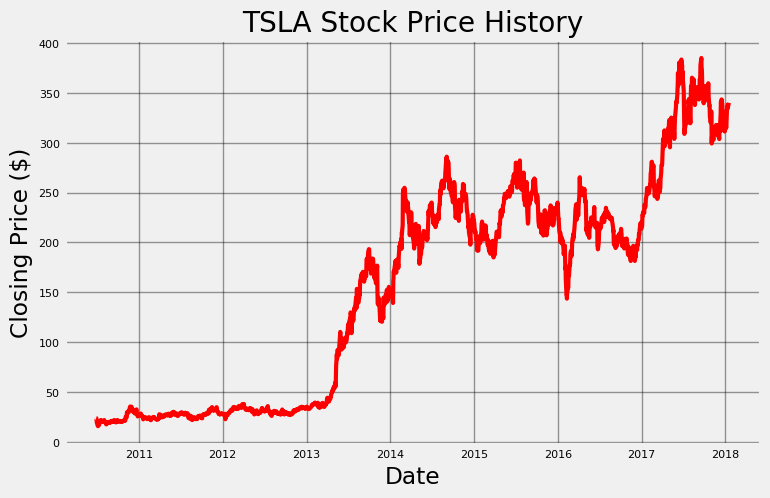

In [48]:
tesla.plot_stock()

     cps  train_err  train_range    test_err  test_range
0  0.001  16.329858    43.342208  105.008674   43.162514
1  0.050  14.139827    44.462230  140.347507   44.865424
2  0.100  11.625297    36.917102  116.684483   97.397816
3  0.200   8.968072    28.125956  103.966826  322.482680


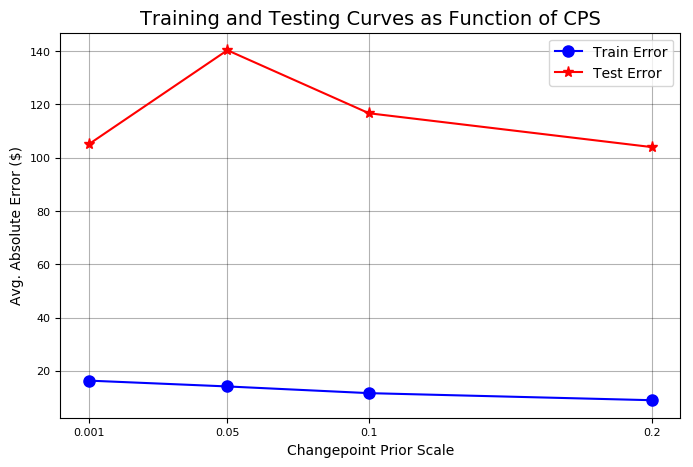

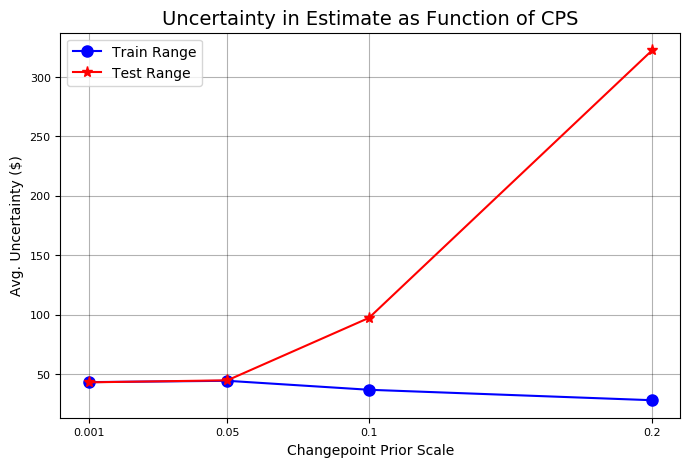

In [49]:
tesla.changepoint_prior_validation()


Predicted Increase: 

         Date    estimate    change       upper       lower
1  2018-01-17  332.628581  0.809813  346.411225  318.516047
2  2018-01-18  333.353379  0.724798  346.309277  319.573781
3  2018-01-19  333.544704  0.191326  347.856651  320.692303
8  2018-01-24  331.426488  0.171660  344.505283  318.012669
9  2018-01-25  331.727200  0.300712  345.109545  318.261754
10 2018-01-26  331.934544  0.207344  345.768214  318.735652

Predicted Decrease: 

        Date    estimate    change       upper       lower
5 2018-01-21  332.208377 -1.336328  345.433276  318.434331
6 2018-01-22  331.497849 -0.710527  345.399744  319.029062
7 2018-01-23  331.254828 -0.243021  345.178520  316.925618


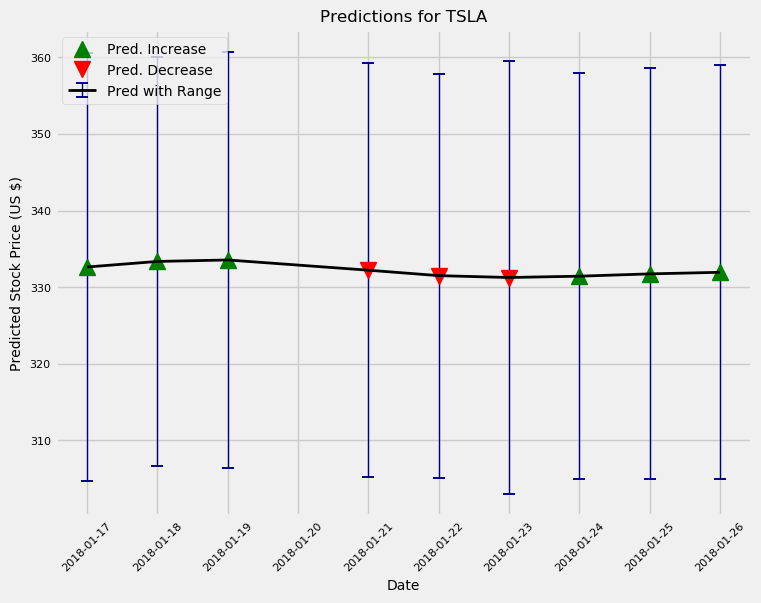

In [50]:
tesla.predict_future(days=10)